Veri Seti Tanımlayıcı İstatistikler:
       Relative_Compactness  Surface_Area   Wall_Area   Roof_Area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167    671.708333  318.500000  176.604167   
std                0.105777     88.086116   43.626481   45.165950   
min                0.620000    514.500000  245.000000  110.250000   
25%                0.682500    606.375000  294.000000  140.875000   
50%                0.750000    673.750000  318.500000  183.750000   
75%                0.830000    741.125000  343.000000  220.500000   
max                0.980000    808.500000  416.500000  220.500000   

       Overall_Height  Orientation  Heating_Load  Cooling_Load  
count       768.00000   768.000000    768.000000    768.000000  
mean          5.25000     3.500000     22.307201     24.587760  
std           1.75114     1.118763     10.090196      9.513306  
min           3.50000     2.000000      6.010000     10.900000  
25%           3.

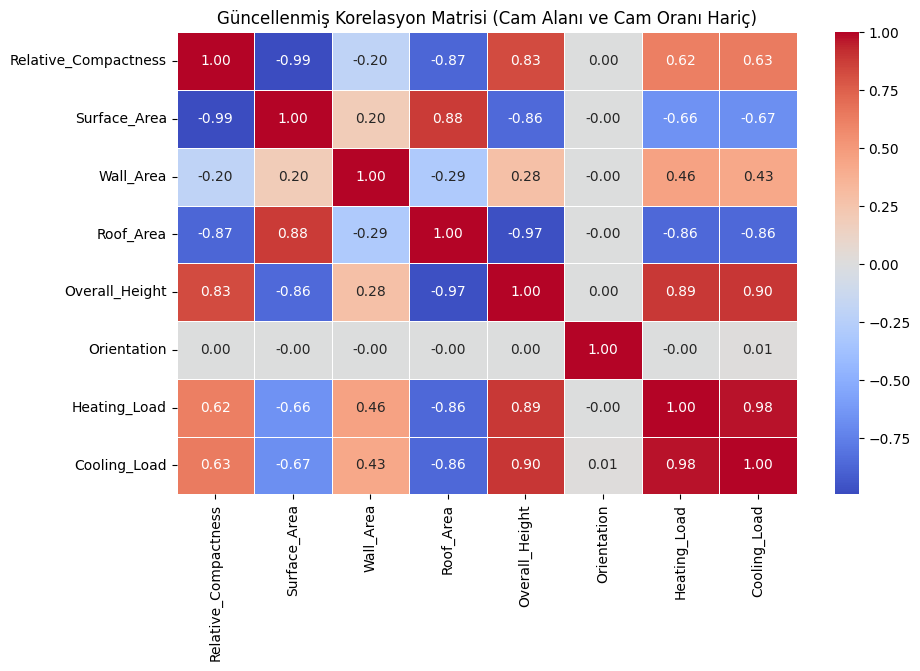

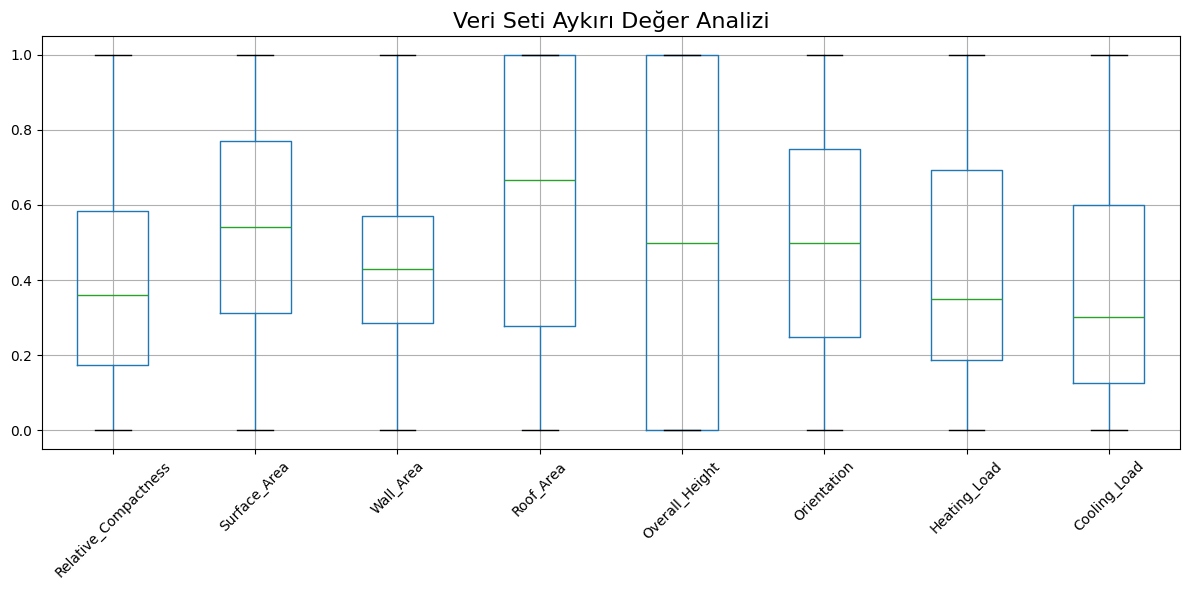

 Fold 1 -> MSE: 16.860, RMSE: 4.106, R²: 0.838, MAE: 3.259, MAPE: 0.159
 Fold 2 -> MSE: 15.396, RMSE: 3.924, R²: 0.848, MAE: 3.086, MAPE: 0.166
 Fold 3 -> MSE: 26.608, RMSE: 5.158, R²: 0.752, MAE: 4.095, MAPE: 0.218
 Fold 4 -> MSE: 17.108, RMSE: 4.136, R²: 0.835, MAE: 3.248, MAPE: 0.151
 Fold 5 -> MSE: 26.630, RMSE: 5.160, R²: 0.698, MAE: 4.122, MAPE: 0.248


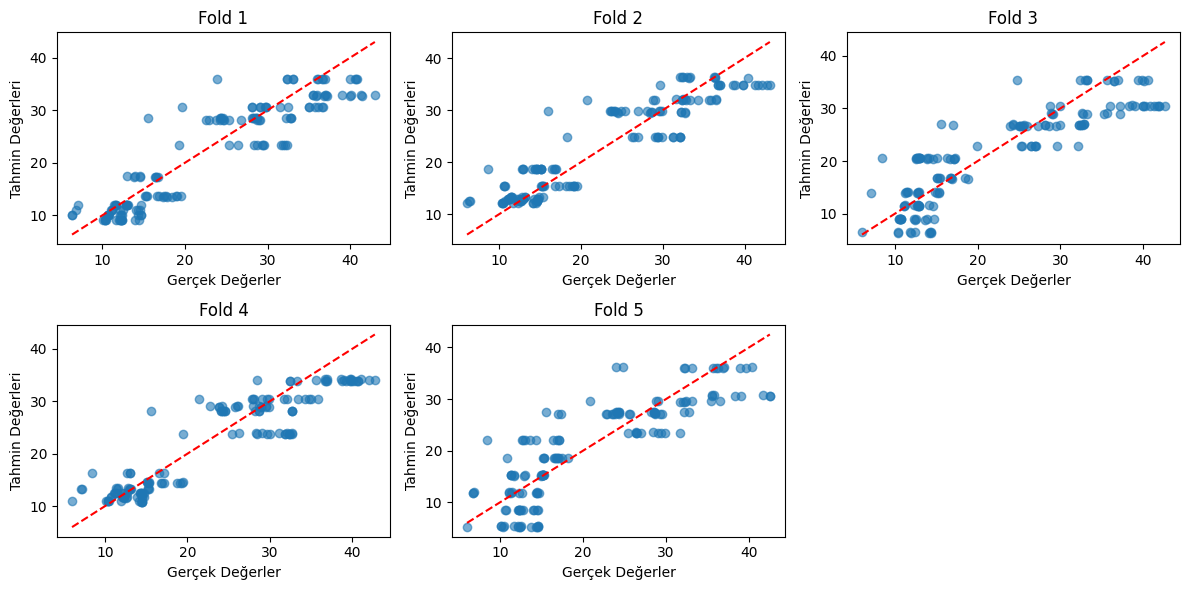


 5-Fold Çapraz Doğrulama Sonuçları:
   Fold        MSE      RMSE        R2       MAE      MAPE
0     1  16.859840  4.106074  0.838246  3.258607  0.159470
1     2  15.395841  3.923753  0.848083  3.086137  0.165823
2     3  26.608195  5.158313  0.752408  4.095250  0.217786
3     4  17.107562  4.136129  0.835042  3.248391  0.150897
4     5  26.630254  5.160451  0.697529  4.122144  0.247739

 Ortalama Performans Metrikleri:
Fold     3.000000
MSE     20.520339
RMSE     4.496944
R2       0.794262
MAE      3.562106
MAPE     0.188343
dtype: float64


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Veri setini yükle
df = pd.read_csv("sample_data/energy_efficiency_data.csv")

# Sütun isimlerini düzenleyelim
df.columns = ["Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
              "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
              "Heating_Load", "Cooling_Load"]

# Glazing_Area ve Glazing_Area_Distribution sütunlarını kaldır
df = df.drop(columns=["Glazing_Area", "Glazing_Area_Distribution"])

# Tanımlayıcı İstatistikler
print("Veri Seti Tanımlayıcı İstatistikler:")
print(df.describe())

# Ortalama ve Medyan Hesaplama
print("\nSütun Bazında Ortalama:")
print(df.mean())
print("\nSütun Bazında Medyan:")
print(df.median())

# Korelasyon Matrisi (Heating Load ile)
corr_matrix_filtered = df.corr()
heating_corr_filtered = corr_matrix_filtered["Heating_Load"].sort_values(ascending=False)
print("\nHeating Load ile Güncellenmiş Korelasyonlar:")
print(heating_corr_filtered)

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_filtered, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Güncellenmiş Korelasyon Matrisi (Cam Alanı ve Cam Oranı Hariç)")
plt.show()

# Aykırı Değer Analizi (Min-Max Normalizasyon)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Boxplot Görselleştirme (Aykırı Değer Analizi)
plt.figure(figsize=(12, 6))
df_normalized[numeric_columns].boxplot(rot=45)
plt.title("Veri Seti Aykırı Değer Analizi", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bağımsız (X) ve Bağımlı (y) Değişkenleri Ayır
X = df.drop(columns=["Heating_Load", "Cooling_Load"])  # Girdi değişkenleri
y = df["Heating_Load"]  # Çıktı değişkeni (Tahmin edilecek değişken)

# Veriyi Eğitim ve Test Olarak Böl (80% Eğitim - 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Yapay Sinir Ağı Modeli (MLPRegressor)
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, random_state=42)

# 5-Fold Çapraz Doğrulama
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
fold_no = 1

plt.figure(figsize=(12, 6))

for train_idx, test_idx in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    mlp.fit(X_train_cv, y_train_cv)
    y_pred_cv = mlp.predict(X_test_cv)

    # Performans Metrikleri
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_cv, y_pred_cv)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mape = mean_absolute_percentage_error(y_test_cv, y_pred_cv)

    cv_results.append([fold_no, mse, rmse, r2, mae, mape])
    print(f" Fold {fold_no} -> MSE: {mse:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}")

    # Görselleştirme - Gerçek vs. Tahmin
    plt.subplot(2, 3, fold_no)
    plt.scatter(y_test_cv, y_pred_cv, alpha=0.6)
    plt.plot([min(y_test_cv), max(y_test_cv)], [min(y_test_cv), max(y_test_cv)], color="red", linestyle="--")
    plt.xlabel("Gerçek Değerler")
    plt.ylabel("Tahmin Değerleri")
    plt.title(f"Fold {fold_no}")

    fold_no += 1

plt.tight_layout()
plt.show()

# Çapraz Doğrulama Sonuçları Tablosu
cv_df = pd.DataFrame(cv_results, columns=["Fold", "MSE", "RMSE", "R2", "MAE", "MAPE"])
print("\n 5-Fold Çapraz Doğrulama Sonuçları:")
print(cv_df)

# Ortalama Performans Metrikleri
print("\n Ortalama Performans Metrikleri:")
print(cv_df.mean())





 **Eğitim Süreci Başlıyor:**

 Epoch |    Loss    |    MSE     |    R²    |    MAE    |    MAPE (%)   
-------|-----------|-----------|----------|-----------|--------------
     1 | 279.893239 |   568.8097 |  -4.4572 |    21.5559 |      92.5416%
     2 | 257.030074 |   526.7885 |  -4.0540 |    20.5596 |      87.0697%
     3 | 239.537650 |   497.2928 |  -3.7710 |    19.8281 |      83.0409%
     4 | 227.241717 |   474.9868 |  -3.5570 |    19.2561 |      79.8880%
     5 | 217.062227 |   454.5308 |  -3.3608 |    18.7169 |      76.9201%
     6 | 207.450546 |   435.0218 |  -3.1736 |    18.1880 |      74.0104%
     7 | 198.271674 |   416.1263 |  -2.9923 |    17.6608 |      71.1101%
     8 | 189.239442 |   397.2770 |  -2.8115 |    17.1186 |      68.1274%
     9 | 180.324866 |   378.9487 |  -2.6356 |    16.5745 |      65.1347%
    10 | 171.679592 |   360.9947 |  -2.4634 |    16.0383 |      62.3311%
    11 | 163.189288 |   343.3347 |  -2.2940 |    15.5039 |      59.6466%
    12 | 154.804934 |  

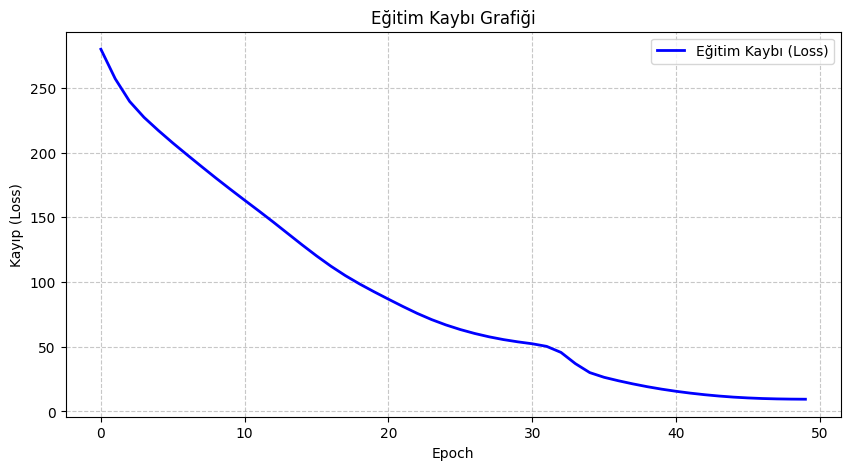

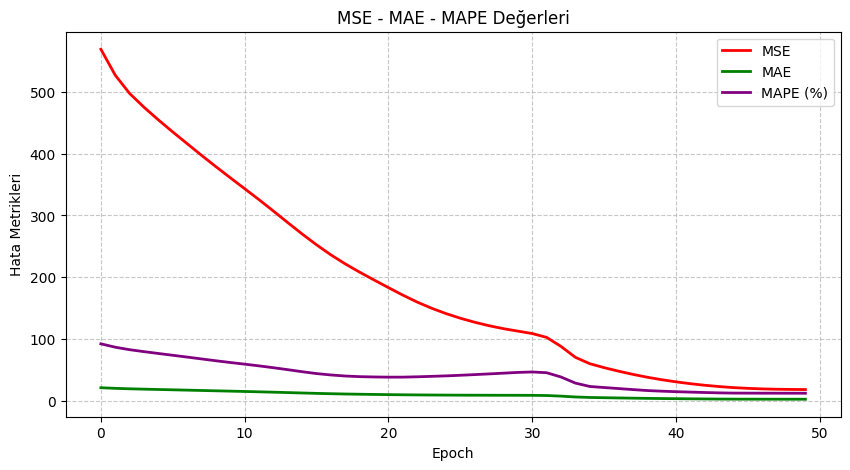

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor

# Uyarıları kapatalım
warnings.filterwarnings("ignore", category=UserWarning)

# Veri ön işleme
X = df.drop(columns=["Heating_Load"])  # Bağımsız değişkenler
y = df["Heating_Load"]  # Hedef değişken

#  Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Veriyi ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Epoch sayısını belirleyelim**
epochs = 50  # Buradan epoch sayısını değiştirebilirsiniz

#  MLP Modelini Tanımla
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='logistic',
    solver='adam',
    max_iter=1,  # Her iterasyonda 1 kez eğiteceğimiz için max_iter=1
    random_state=42,
    validation_fraction=0.1,
    warm_start=True,
    batch_size=32,
    verbose=0  # Terminalde gereksiz çıktı olmasını engeller
)



#  Eğitim sürecini takip için listeler
train_losses = []
mse_list, r2_list, mae_list, mape_list = [], [], [], []

print("\n **Eğitim Süreci Başlıyor:**\n")
print(" Epoch |    Loss    |    MSE     |    R²    |    MAE    |    MAPE (%)   ")
print("-------|-----------|-----------|----------|-----------|--------------")

for epoch in range(epochs):
    mlp.fit(X_train, y_train)  # Modeli eğit

    # Test seti tahminleri
    y_pred = mlp.predict(X_test)

    # Hata metriklerini hesapla
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # Eğitim kaybını sakla
    train_losses.append(mlp.loss_)
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)
    mape_list.append(mape)

    #  Düzenli ve hizalı bir formatta çıktı verelim
    print(f" {epoch+1:5d} | {mlp.loss_:10.6f} | {mse:10.4f} | {r2:8.4f} | {mae:10.4f} | {mape:12.4f}%")

print("\n Model eğitimi tamamlandı.")

#  Sonuçları yazdır
print("\n **Model Performans Sonuçları:**")
print(f" Son R² Skoru: {r2:.4f}")
print(f" Son MSE: {mse:.4f}")
print(f" Son MAE: {mae:.4f}")
print(f" Son MAPE: {mape:.4f}%")

#  Eğitim Kaybı Grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Eğitim Kaybı (Loss)", color="blue", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Kayıp (Loss)")
plt.title("Eğitim Kaybı Grafiği")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#  Hata Metrikleri Grafiği
plt.figure(figsize=(10, 5))
plt.plot(mse_list, label="MSE", color="red", linewidth=2)
plt.plot(mae_list, label="MAE", color="green", linewidth=2)
plt.plot(mape_list, label="MAPE (%)", color="purple", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Hata Metrikleri")
plt.title("MSE - MAE - MAPE Değerleri")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


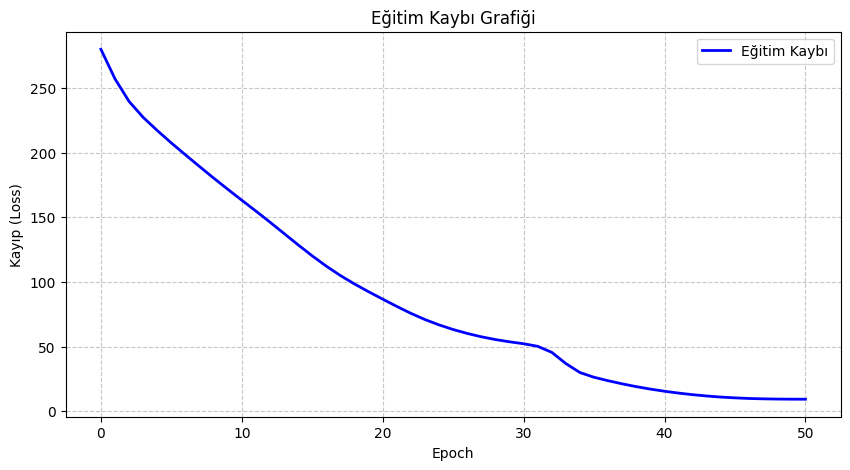

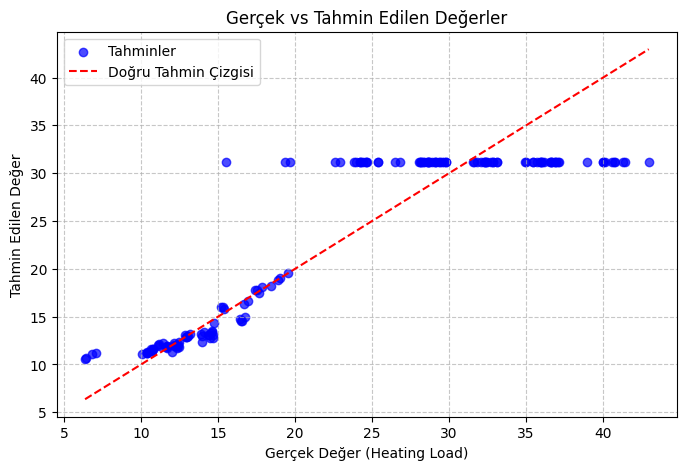

In [4]:
# **Veri Önişleme**
X = df.drop(columns=["Heating_Load"])  # Bağımsız değişkenler
y = df["Heating_Load"]  # Hedef değişken

# Eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Modeli eğit
mlp.fit(X_train, y_train)

# **Model Tahminleri**
y_pred = mlp.predict(X_test)

# **Hata Metrikleri**
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


# **Eğitim Kaybı Görselleştirme**
plt.figure(figsize=(10, 5))
plt.plot(mlp.loss_curve_, label="Eğitim Kaybı", color="blue", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Kayıp (Loss)")
plt.title("Eğitim Kaybı Grafiği")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# **Gerçek vs Tahmin Edilen Değerler Grafiği**
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, label="Tahminler", color="blue")
plt.xlabel("Gerçek Değer (Heating Load)")
plt.ylabel("Tahmin Edilen Değer")
plt.title("Gerçek vs Tahmin Edilen Değerler")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle="--", label="Doğru Tahmin Çizgisi")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
